Module 8: Aggregating Pandas DataFrames

CPE311 Computational Thinking with Python

Submitted by: Mendoza, Paulo

Performed on: 03/28/2023

Submitted on: 03/28/2023

Submitted to: Engr.Roman M. Richard

Hands-on Activity 8.1: Aggregating Data with Pandas

8.1.1 Intended Learning Outcomes

After this activity, the student should be able to:

Demonstrate querying and merging of dataframes

Perform advanced calculations on dataframes

Aggregate dataframes with pandas and numpy

Work with time series data


8.1.2 Resources

Computing Environment using Python 3.x

Attached Datasets (under Instructional Materials)


8.1.3 Procedures

The procedures can be found in the canvas module. Check the following under topics:

8.1 Weather Data Collection

8.2 Querying and Merging

8.3 Dataframe Operations

8.4 Aggregations

8.5 Time Series

Collecting weather date from an API

About the data

In this notbook, we will be collecting daily weather data from the National Centers for Environmental Information (NCEI) API.


8.1 Weather Data Collection


Mendoza, Paulo D.C.

CPE22S5

In [ ]:
import requests

def make_request(endpoint, payload=None):
  """
  Make a request to a specific endpoint on the weather API
  passing headers and optional payload.

  Parameters:
    - endpoint: The endpoint of the API you want to make a
                GET request to.
    - payload: A dictionary of data to pass along with the
                request.
  Returns:
    Response object.
  """
  return requests.get(
      f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
      headers={
          'token' : 'YEhFukPCAbfHdzhKSFxTxBtDXKgaGjjP'
          },
          params=payload
  )

Collect All Data Points for 2018 In NYC (Various Stations)

In [ ]:
import datetime

from IPython import display # for updating the cell dynamically

current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)

results = []

while current < end:
  #update the cell with status information
  display.clear_output(wait = True)
  display.display(f'Gathering data for {str(current)}')

  response = make_request(
      'data',
      {
          'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
          'locationid' : 'CITY:US360019', #NYC
          'startdate' : current,
          'enddate' : current,
          'units' : 'metric',
          'limit' : 1000 # max allowed
      }
  )
  if response.ok:
    # we extend the list instead of appending to avoid getting a nested list
    results.extend(response.json()['results'])

  # update the current date to avoid an infinite loop
  current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

In [ ]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [ ]:
df.to_csv('/content/nyc_weather_2018.csv', index = False)

In [ ]:
import sqlite3

with sqlite3.connect('/content/weather.db') as connection:
  df.to_sql(
      'weather', connection, index = False, if_exists = 'replace'
  )

In [ ]:
response = make_request(
    'stations',
    {
        'datasetid' : 'GHCND', #Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid' : 'CITY:US360019', # NYC
        'limit' : 1000 # max allowed
    }
)

stations = pd.DataFrame(response.json()['results'])[['id','name','latitude','elevation']]
stations.to_csv('/content/weather_stations.csv', index = False)
with sqlite3.connect('/content/weather.db') as connection:
  stations.to_sql(
      'stations', connection, index = False, if_exists = 'replace'
  )

In [ ]:
with sqlite3.connect('/content/weather.db') as connection:
  stations.to_sql(
      'stations', connection, index = False, if_exists = 'replace'
  )

8.2 Querying and Merging

Database-style Operations on Dataframes

Background on the data

Data meanings:

PRCP: precipitations in millimeters

SNOW: snowfall in millimeters

SNWD: snow depth in millimeters

TMAX: maximum daily temperature in Celsius

TMIN: minimum daily temperature in Celsius

TOBS: temperature at time of observation in Celsius

WESF: water equivalent of snow in millimeters

In [ ]:
import pandas as pd

weather = pd.read_csv('/content/nyc_weather_2018.csv')
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [ ]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
816,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
819,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
823,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
830,2018-01-04T00:00:00,SNOW,GHCND:US1NJES0018,",,N,0700",10.0


In [ ]:
import sqlite3

with sqlite3.connect('/content/weather.db')as connection:
  snow_data_from_db = pd.read_sql(
      'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
      connection
  )

snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [ ]:
weather[(weather.datatype == 'SNOW') & (weather.value>0)].equals(snow_data)

True

Merging DataFrames

In [ ]:
station_info = pd.read_csv('/content/weather_stations.csv')
station_info.head()

,id,name,latitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,21.6


In [ ]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [ ]:
station_info.id.describe()

count                   312
unique                  312
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

In [ ]:
weather.station.describe()

count                 91448
unique                  114
top       GHCND:USW00014734
freq                   6762
Name: station, dtype: object

In [ ]:
station_info.shape[0], weather.shape[0]

(312, 91448)

In [ ]:
def get_row_count(*dfs):
  return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[312, 91448]

In [ ]:
def get_info(attr, *dfs):
  return list(map(lambda x: getattr(x,attr),dfs))
get_info('shape', station_info, weather)

[(312, 4), (91448, 5)]

In [ ]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,elevation
41936,2018-09-28T00:00:00,PRCP,GHCND:USC00301309,",,7,0700",38.4,GHCND:USC00301309,"CENTERPORT, NY US",40.883450,9.1
35890,2018-10-12T00:00:00,TMAX,GHCND:USC00281335,",,7,0700",23.9,GHCND:USC00281335,"CANOE BROOK, NJ US",40.743600,54.9
36580,2018-02-06T00:00:00,TMAX,GHCND:USC00283704,",,7,0700",3.9,GHCND:USC00283704,"HARRISON, NJ US",40.748100,7.3
86684,2018-05-18T00:00:00,PRCP,GHCND:US1NJUN0028,",,N,0800",1.3,GHCND:US1NJUN0028,"SPRINGFIELD TWP 0.7 NNE, NJ US",40.708904,37.5
68200,2018-08-27T00:00:00,ASTP,GHCND:USW00094728,",,W,",10132.0,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.778980,42.7


In [ ]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on = 'station').sample(5, random_state=0)

,date,datatype,station,attributes,value,name,latitude,elevation
41936,2018-09-28T00:00:00,PRCP,GHCND:USC00301309,",,7,0700",38.4,"CENTERPORT, NY US",40.883450,9.1
35890,2018-10-12T00:00:00,TMAX,GHCND:USC00281335,",,7,0700",23.9,"CANOE BROOK, NJ US",40.743600,54.9
36580,2018-02-06T00:00:00,TMAX,GHCND:USC00283704,",,7,0700",3.9,"HARRISON, NJ US",40.748100,7.3
86684,2018-05-18T00:00:00,PRCP,GHCND:US1NJUN0028,",,N,0800",1.3,"SPRINGFIELD TWP 0.7 NNE, NJ US",40.708904,37.5
68200,2018-08-27T00:00:00,ASTP,GHCND:USW00094728,",,W,",10132.0,"NY CITY CENTRAL PARK, NY US",40.778980,42.7


In [ ]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')

right_join.tail()

,date,datatype,station,attributes,value,id,name,latitude,elevation
91641,2018-12-31T00:00:00,WDF5,GHCND:USW00094789,",,W,",130.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,2.7
91642,2018-12-31T00:00:00,WSF2,GHCND:USW00094789,",,W,",9.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,2.7
91643,2018-12-31T00:00:00,WSF5,GHCND:USW00094789,",,W,",12.5,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,2.7
91644,2018-12-31T00:00:00,WT01,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,2.7
91645,2018-12-31T00:00:00,WT02,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,2.7


In [ ]:
left_join.sort_index(axis=1).sort_values(['date','station']).reset_index().drop(columns='index').equals(
    right_join.sort_index(axis=1).sort_values(['date','station']).reset_index().drop(columns='index')
)

True

In [ ]:
get_info('shape', inner_join, left_join, right_join)

[(91448, 9), (91646, 9), (91646, 9)]

In [ ]:
outer_join = weather.merge(
    station_info[station_info.name.str.contains('NY')],
    left_on = 'station', right_on='id',how='outer',indicator=True
)

outer_join.sample(4,random_state=0).append(outer_join[outer_join.station.isna()].head(2))

<ipython-input-97-fcaffab44ff1>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outer_join.sample(4,random_state=0).append(outer_join[outer_join.station.isna()].head(2))


,date,datatype,station,attributes,value,id,name,latitude,elevation,_merge
22325,2018-12-23T00:00:00,PRCP,GHCND:US1NYNS0007,",,N,0700",0.3,GHCND:US1NYNS0007,"FLORAL PARK 0.4 W, NY US",40.723000,24.1,both
18929,2018-03-07T00:00:00,SNOW,GHCND:US1NJPS0025,",,N,0600",10.0,NaN,NaN,NaN,NaN,left_only
49047,2018-10-04T00:00:00,WSF2,GHCND:USW00014732,",,W,",6.3,GHCND:USW00014732,"LAGUARDIA AIRPORT, NY US",40.779450,3.0,both
20030,2018-05-29T00:00:00,PRCP,GHCND:US1NJUN0010,",,N,0730",0.0,NaN,NaN,NaN,NaN,left_only
91448,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0018,"KEARNY 1.7 NNW, NJ US",40.774342,25.6,right_only
91449,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJMS0036,"PARSIPPANY TROY HILLS TWP 2.1 E, NJ US",40.865600,64.3,right_only


In [ ]:

import sqlite3
with sqlite3.connect('/content/weather.db') as connection:
 inner_join_from_db = pd.read_sql(
 'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
 connection
 )
inner_join_from_db.shape == inner_join.shape


True

In [ ]:

dirty_data = pd.read_csv(
 '/content/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [ ]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [ ]:
valid_station.merge(
 station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()


,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [ ]:
valid_station.merge(
 station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()


,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [ ]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [ ]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [ ]:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:USC00284987', 'GHCND:US1NJES0031', 'GHCND:US1NJES0029',
       'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097', 'GHCND:US1NJMN0081',
       'GHCND:US1NJMD0088', 'GHCND:US1NJES0033', 'GHCND:US1NJES0040',
       'GHCND:US1NYQN0029'],
      dtype='object', length=114)

In [ ]:

weather.index.difference(station_info.index)

Index([], dtype='object')

In [ ]:
station_info.index.difference(weather.index)


Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=198)

In [ ]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]


True

8.3 Dataframe Operations

In [ ]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=312)

In [ ]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
 weather.index.symmetric_difference(ny_in_name.index)
)

True

DataFrame Operations

In [ ]:

import numpy as np
import pandas as pd
weather = pd.read_csv('/content/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()


,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [ ]:
fb = pd.read_csv('/content/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()


,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [ ]:

fb.assign(
 abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [ ]:

fb.assign(
 volume_pct_change=fb.volume.pct_change(),
 pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
 ascending=False
 )
).nsmallest(5, 'pct_change_rank')


,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [ ]:

fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [ ]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [ ]:

(fb > 215).all()


open      False
high      False
low       False
close     False
volume     True
dtype: bool

In [ ]:
(fb.volume.value_counts() > 1).sum()


0

In [ ]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

low     240
med       8
high      3
Name: volume, dtype: int64

In [ ]:
fb[volume_binned == 'high'].sort_values(
 'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [ ]:

fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [ ]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


In [ ]:

import matplotlib.pyplot as plt


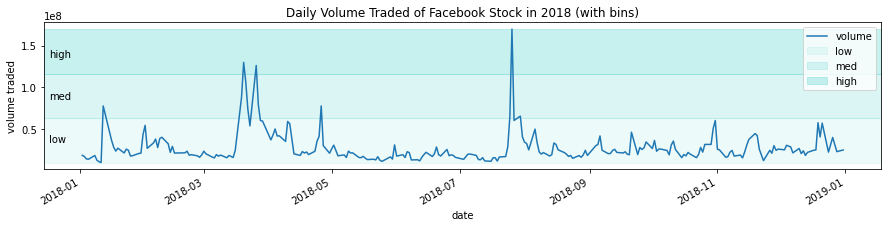

In [ ]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')
for bin_name, alpha, bounds in zip(
 ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [ ]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

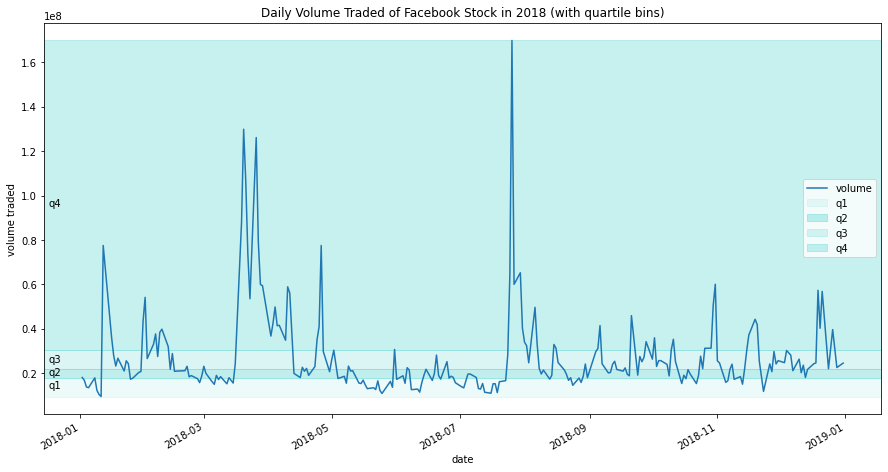

In [ ]:

fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
 ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [ ]:

central_park_weather = weather.query(
 'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')


In [ ]:

central_park_weather.SNOW.clip(0, 1).value_counts()

0.0    351
1.0     11
Name: SNOW, dtype: int64

In [ ]:
 oct_weather_z_scores = central_park_weather.loc[
     '2018-10', ['TMIN', 'TMAX', 'PRCP']

].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T


,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,30.0,-2.257453e-16,1.0,-1.314572,-0.717039,-0.435847,1.079953,1.919135
TMAX,30.0,-4.616677e-16,1.0,-1.279024,-0.864062,-0.148915,0.998851,1.669854
PRCP,30.0,2.590520e-17,1.0,-0.401814,-0.401814,-0.401814,-0.239899,3.867458


In [ ]:

oct_weather_z_scores.query('PRCP > 3')


datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.717039,-1.173077,3.867458


In [ ]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    30.000000
mean      3.040000
std       7.565694
min       0.000000
25%       0.000000
50%       0.000000
75%       1.225000
max      32.300000
Name: PRCP, dtype: float64

In [ ]:

import numpy as np
fb.apply(
 lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
 fb.applymap(lambda x: len(str(np.ceil(x))))
)

True

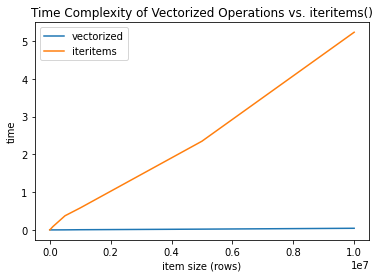

In [ ]:

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
vectorized_results = {}
iteritems_results = {}
for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
 test = pd.Series(np.random.uniform(size=size))

 start = time.time()
 x = test + 10
 end = time.time()
 vectorized_results[size] = end - start

 start = time.time()
 x = []
 for i, v in test.iteritems():
  x.append(v + 10)
 x = pd.Series(x)
 end = time.time()
 iteritems_results[size] = end - start
pd.DataFrame(
 [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()


In [ ]:

central_park_weather['2018-10'].assign(
 rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T


<ipython-input-147-ae7842e6fdff>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'].assign(


date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [ ]:
central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]


<ipython-input-148-2abb37634d3b>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]


datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-01,172.000000,10247.000000,10200.000000,189.000000,0.900000,0.000000
2018-10-02,180.500000,10221.500000,10176.000000,194.500000,0.900000,8.750000
2018-10-03,172.333333,10205.333333,10159.000000,187.000000,0.966667,5.833333
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-06,157.333333,10194.333333,10145.333333,170.333333,0.833333,0.333333
2018-10-07,163.000000,10217.000000,10165.666667,177.666667,1.066667,0.000000


In [ ]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [ ]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

In [ ]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
 {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_expanding'
).sort_index(axis=1)


datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


In [ ]:

fb.assign(
 close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


In [ ]:
def get_info(df):
 return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
 == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

<ipython-input-153-df4ec8f2b7d9>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
<ipython-input-153-df4ec8f2b7d9>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))


True

In [ ]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

In [ ]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

In [ ]:
def window_calc(df, func, agg_dict, *args, **kwargs):
 """
 Run a window calculation of your choice on a DataFrame.

 Parameters:
 - df: The DataFrame to run the calculation on.
 - func: The window calculation method that takes df
 as the first argument.
 - agg_dict: Information to pass to `agg()`, could be a
 dictionary mapping the columns to the aggregation
function to use, a string name for the function,
or the function itself.
 - args: Positional arguments to pass to `func`.
 - kwargs: Keyword arguments to pass to `func`.

 Returns:
 - A new DataFrame object.
 """
 return df.pipe(func, *args, **kwargs).agg(agg_dict)

In [ ]:
 window_calc(fb, pd.DataFrame.expanding, np.median).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.580,177.5500,181.420,18151903.0
2018-01-03,179.78,183.180,179.4400,183.045,17519233.0
2018-01-04,181.88,184.780,181.3300,184.330,16886563.0
2018-01-05,183.39,185.495,182.7148,184.500,15383729.5
2018-01-08,184.90,186.210,184.0996,184.670,16886563.0


In [ ]:

window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()


,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


In [ ]:

window_calc(
 central_park_weather['2018-10'],
 pd.DataFrame.rolling,
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
 '3D'
).head()

<ipython-input-159-9c6c3549bb1a>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  central_park_weather['2018-10'],


datatype,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0


8.4 Aggregations

Aggregations with pandas and numpy

In [ ]:
import numpy as np
import pandas as pd

weather = pd.read_csv('/content/weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()


,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [ ]:
fb = pd.read_csv('/content/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low','med','high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
fb.agg({
    'open': np.mean,
    'high': np.max,
    'low': np.min,
    'close': np.mean,
    'volume': np.sum
})

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [ ]:
weather.query(
    'station == "GHCND:USW00094728"'
).pivot(columns='datatype',values='value')[['SNOW','PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [ ]:
weather.query(
    'station == "GHCND:USW00094728"'

).pivot(columns='datatype',values='value')[['SNOW','PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [ ]:
fb.agg({
    'open':'mean',
    'high': ['min', 'max'],
    'low':['min','max'],
    'close':'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


In [ ]:
fb.groupby('trading_volume').mean()


,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [ ]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])


,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [ ]:

fb_agg = fb.groupby('trading_volume').agg({
 'open': 'mean',
 'high': ['min', 'max'],
 'low': ['min', 'max'],
 'close': 'mean'
})
fb_agg


open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [ ]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [ ]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()


,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


In [ ]:
weather['2018-10'].query('datatype == "PRCP"').groupby(
 pd.Grouper(freq='D')
).mean().head()

<ipython-input-22-76c293b88779>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  weather['2018-10'].query('datatype == "PRCP"').groupby(


,value
date,
2018-10-01,0.01
2018-10-02,2.23
2018-10-03,19.69
2018-10-04,0.32
2018-10-05,0.97


In [ ]:
weather.query('datatype == "PRCP"').groupby(
 ['station_name', pd.Grouper(freq='Q')]
).sum().unstack().sample(5, random_state=1)

value                                 
date                        2018-03-31 2018-06-30 2018-09-30 2018-12-31
station_name                                                           
WANTAGH 1.1 NNE, NY US          279.90     216.80     472.50     277.20
STATEN ISLAND 1.4 SE, NY US     379.40     295.30     438.80     409.90
SYOSSET 2.0 SSW, NY US          323.50     263.30     355.50     459.90
STAMFORD 4.2 S, CT US           338.00     272.10     424.70     390.00
WAYNE TWP 0.8 SSW, NJ US        246.20     295.30     620.90     422.00

In [ ]:
weather.groupby('station').filter( # station IDs with NY in them
 lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name').sum().squeeze() # aggregate and make a series (squeeze)


station_name
ALBERTSON 0.2 SSE, NY US         1087.00
AMITYVILLE 0.1 WSW, NY US         434.00
AMITYVILLE 0.6 NNE, NY US        1072.00
ARMONK 0.3 SE, NY US             1504.00
BROOKLYN 3.1 NW, NY US            305.00
CENTERPORT 0.9 SW, NY US          799.00
ELMSFORD 0.8 SSW, NY US           863.00
FLORAL PARK 0.4 W, NY US         1015.00
HICKSVILLE 1.3 ENE, NY US         716.00
JACKSON HEIGHTS 0.3 WSW, NY US    107.00
LOCUST VALLEY 0.3 E, NY US          0.00
LYNBROOK 0.3 NW, NY US            325.00
MASSAPEQUA 0.9 SSW, NY US          41.00
MIDDLE VILLAGE 0.5 SW, NY US     1249.00
NEW HYDE PARK 1.6 NE, NY US         0.00
NEW YORK 8.8 N, NY US               0.00
NORTH WANTAGH 0.4 WSW, NY US      471.00
PLAINEDGE 0.4 WSW, NY US          610.00
PLAINVIEW 0.4 ENE, NY US         1360.00
SADDLE ROCK 3.4 WSW, NY US        707.00
STATEN ISLAND 1.4 SE, NY US       936.00
STATEN ISLAND 4.5 SSE, NY US       89.00
SYOSSET 2.0 SSW, NY US           1039.00
VALLEY STREAM 0.6 SE, NY US       898.00
WAN

In [ ]:
weather.query('datatype == "PRCP"').groupby(
 pd.Grouper(freq='D')
).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest()

date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

In [ ]:
weather.query('datatype == "PRCP"').rename(
 dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D')).mean().groupby(
 pd.Grouper(freq='M')
).transform(np.sum)['2018-01-28':'2018-02-03']


,prcp
date,
2018-01-28,69.31
2018-01-29,69.31
2018-01-30,69.31
2018-01-31,69.31
2018-02-01,158.11
2018-02-02,158.11
2018-02-03,158.11


In [ ]:
weather\
 .query('datatype == "PRCP"')\
 .rename(dict(value='prcp'), axis=1)\
 .groupby(pd.Grouper(freq='D')).mean()\
 .assign(
 total_prcp_in_month=lambda x: x.groupby(
 pd.Grouper(freq='M')
 ).transform(np.sum),
 pct_monthly_prcp=lambda x: x.prcp.div(
 x.total_prcp_in_month
 )
 ).nlargest(5, 'pct_monthly_prcp')


,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


In [ ]:
fb[['open', 'high', 'low', 'close']].transform(
 lambda x: (x - x.mean()).div(x.std())
).head()


,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


In [ ]:
fb.pivot_table(columns='trading_volume')

trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [ ]:
fb.pivot_table(index='trading_volume')

,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [ ]:
weather.reset_index().pivot_table(
 index=['date', 'station', 'station_name'],
 columns='datatype',
 values='value',
 aggfunc='median'
).reset_index().tail()

datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'] # name the columns index
)


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [ ]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 normalize='columns'
)


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [ ]:

pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 values=fb.close,
 aggfunc=np.mean
)


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [ ]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
 index=snow_data.station_name,
 columns=snow_data.index.month,
 colnames=['month'],
 values=snow_data.value,
 aggfunc=lambda x: (x > 0).sum(),
 margins=True, # show row and column subtotals
 margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


8.5 Time Series


Time Series

In [ ]:
import numpy as np
import pandas as pd
fb = pd.read_csv('/content/fb_2018.csv', index_col='date', parse_dates=True).assign(
 trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


In [ ]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [ ]:
fb['2018-q1'].equals(fb['2018-01':'2018-03'])

<ipython-input-39-f01e3c270a70>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-q1'].equals(fb['2018-01':'2018-03'])


True

In [ ]:
fb.first('1W')

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [ ]:
fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [ ]:
stock_data_per_minute = pd.read_csv(
 '/content/fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
 date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [ ]:

stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [ ]:
stock_data_per_minute.at_time('9:30')


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [ ]:

stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [ ]:
shares_traded_in_first_30_min = stock_data_per_minute\
 .between_time('9:30', '10:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_last_30_min = stock_data_per_minute\
 .between_time('15:30', '16:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_first_30_min - shares_traded_in_last_30_min


18592.967741935485

In [ ]:

pd.DataFrame(
 dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()


,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [ ]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

In [ ]:
fb.assign(
 prior_close=lambda x: x.close.shift(),
 after_hours_change_in_price=lambda x: x.open - x.prior_close,
 abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [ ]:

pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')


DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
fb['2018-09'].first_valid_index()


<ipython-input-52-d8ca41528993>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-09'].first_valid_index()


Timestamp('2018-09-04 00:00:00')

In [ ]:
fb['2018-09'].last_valid_index()


<ipython-input-53-ef6e024573c9>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-09'].last_valid_index()


Timestamp('2018-09-28 00:00:00')

In [ ]:
fb.asof('2018-09-30')

open                  168.33
high                  168.79
low                   162.56
close                 164.46
volume           34265638.00
trading_volume           low
Name: 2018-09-30 00:00:00, dtype: object

In [ ]:

(
 fb.drop(columns='trading_volume')
 - fb.drop(columns='trading_volume').shift()
).equals(
 fb.drop(columns='trading_volume').diff()
)


True

In [ ]:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [ ]:
fb.drop(columns='trading_volume').diff(-3).head()


,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


In [ ]:
import matplotlib.pyplot as plt

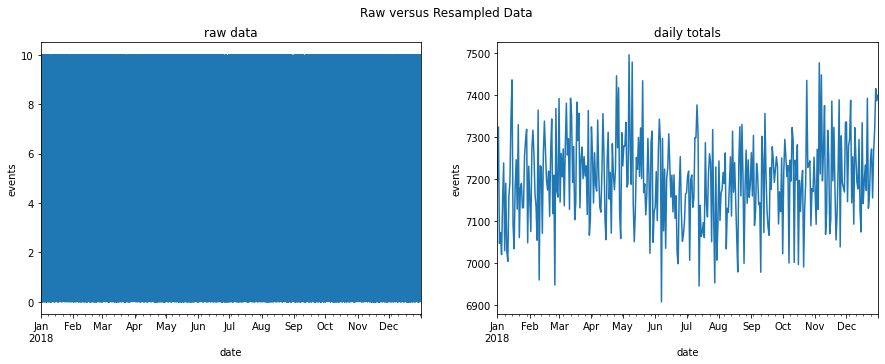

In [ ]:

np.random.seed(0)
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
 np.random.uniform(0, 10, size=index.shape[0]), index=index
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
 ax.set_xlabel('date')
 ax.set_ylabel('events')

plt.suptitle('Raw versus Resampled Data')
plt.show()

In [ ]:
stock_data_per_minute.head()


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [ ]:
stock_data_per_minute.resample('1D').agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})


,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [ ]:
fb.resample('Q').mean()

,open,high,low,close,volume
date,,,,,
2018-03-31,179.47,181.79,177.04,179.55,32926396.70
2018-06-30,180.37,182.28,178.60,180.70,24055317.75
2018-09-30,180.81,182.89,178.96,181.03,27019824.76
2018-12-31,145.27,147.62,142.72,144.87,26974331.73


In [ ]:
fb.drop(columns='trading_volume').resample('Q').apply(
 lambda x: x.last('1D').values - x.first('1D').values
)


date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: Q-DEC, dtype: object

In [ ]:
melted_stock_data = pd.read_csv('/content/melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [ ]:
melted_stock_data.resample('1D').ohlc()['price']


,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [ ]:
fb.resample('6H').asfreq().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [ ]:
fb.resample('6H').pad().head()

<ipython-input-75-39179f05e435>:1: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  fb.resample('6H').pad().head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [ ]:
fb.resample('6H').fillna('nearest').head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [ ]:

fb.resample('6H').asfreq().assign(
 volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
 close=lambda x: x.close.fillna(method='ffill'), # carry forward
 # take the closing price if these aren't available
 open=lambda x: np.where(x.open.isnull(), x.close, x.open),
 high=lambda x: np.where(x.high.isnull(), x.close, x.high),
 low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [ ]:

import sqlite3
with sqlite3.connect('/content/stocks.db') as connection:
 fb_prices = pd.read_sql(
 'SELECT * FROM fb_prices', connection,
 index_col='date', parse_dates=['date']
 )
 aapl_prices = pd.read_sql(
 'SELECT * FROM aapl_prices', connection,
 index_col='date', parse_dates=['date']
 )


In [ ]:

fb_prices.index.second.unique()


Int64Index([0], dtype='int64', name='date')

In [ ]:
aapl_prices.index.second.unique()


Int64Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19,
            53, 11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50,
            31, 58, 48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32,
            27, 30, 45,  1, 44, 57, 41, 37, 28],
           dtype='int64', name='date')

In [ ]:
pd.merge_asof(
 fb_prices, aapl_prices,
 left_index=True, right_index=True, # datetimes are in the index
 # merge with nearest minute
 direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:33:00,182.95,182.50
2019-05-20 09:34:00,183.06,182.11


In [ ]:
pd.merge_ordered(
 fb_prices.reset_index(), aapl_prices.reset_index()
).set_index('date').head()


,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:31:52,NaN,182.87
2019-05-20 09:32:00,182.75,NaN
2019-05-20 09:32:36,NaN,182.50


In [ ]:
pd.merge_ordered(
 fb_prices.reset_index(), aapl_prices.reset_index(),
 fill_method='ffill'
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,183.52
2019-05-20 09:31:52,182.61,182.87
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:32:36,182.75,182.50


8.1.4 Data Analysis

8.1 Weather Data Collection

We get data on NCEI using their API. Then store those data into dataframes using Pandas. We were also able to save it as a csv (comma-separated values) file. Then we are introduced to sqlite3 which is a database management system.

8.2 Querying and Merging

We were able to display values in the using sqlite3 it is like mySQL. Then we were able to merge dataframes using merge and explore different types of merges. Then tried merging as well using swlite3

8.3 Dataframe Operations

We were able to analyse and make statistical computations using data set that were in csv file. We are also introduced to matplotlib for a graphical representation of our data.

8.4 Aggregations

We were able to rearrage the data in our dataframe by using different methods. We were able to add arguments to specify what data we would like to see, how it is arrange, how it is labeled and more. Notable methods of the dataframe was groupby(), pivot_table(), and crosstab().

8.5 Time Series

Time is an important type of data especially when dealing with time dependent information. Example of this are prices of stocks another example can be time on when a research data was gathered. shift() is a method that is very useful in this scenario.





8.1.5 Supplementary Activity
